In [1]:
import numpy as np
from scipy import stats
from scipy.optimize import root
import matplotlib.pyplot as plt
""" 5.2_AHP_4L_unbalance_hierarchy_JobSelection_with_subcriteria.ipynb"""

' 5.2_AHP_4L_unbalance_hierarchy_JobSelection_with_subcriteria.ipynb'

In [2]:
""" Load all Helper Functions """
def sensit(C, S, AL, u, v, W):
    """ Perform Sensitivty Analysis """

    # Sensitivity Analysis on main criteria weight
    for k, cr in enumerate(C):
        adj_WG_dict = {}
        for p in np.linspace(0,1,11):
            adj_u = renorm_wt(p, k, u)
            adj_vG = {}
            for i, (c, z) in enumerate(v.items()):
                adj_vG[c] = adj_u[i]*z
            adj_wG = sum([ np.dot(W[c], adj_vG[c]) for c in C ])
            adj_WG_dict[p] = adj_wG
        rainbow_diagram(adj_WG_dict, AL, cr, base_val=u[k])

    # Sensitivty analysis on sub-criteria weights
    for cr in C:
        for k, sc in enumerate(S[cr]):
            if sc is not None:
                adj_v = dict(v) # make a deep copy
                adj_WG_dict = {}
                for p in np.linspace(0,1,11):
                    adj_v[cr] = renorm_wt(p, k, v[cr])
                    adj_vG = {}
                    for i, (cx, z) in enumerate(adj_v.items()):
                        adj_vG[cx] = u[i]*z
                    adj_wG = sum([ np.dot(W[c], adj_vG[c]) for c in C ])
                    adj_WG_dict[p] = adj_wG
                rainbow_diagram(adj_WG_dict, AL, cr, sub_cr=sc, base_val=v[cr][k])
    
            
def rainbow_diagram(w_dict, alternatives, main_cr, sub_cr=None, base_val=None):
    """ Plot the rainbow diagram 
    Parameters:
      w = dictionary of array of alternative weights of the form
            { p : [w1, w2, ..., wn ]  where 0 <= p <= 1.
      alternatives = list of alternatives
      main_cr = main criterion name
      sub_cr = sub-criterion name if any
      base_val = base value of criterion being varied
    """ 
    
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(w_dict.keys(), w_dict.values(), 
             label=alternatives, lw='2')
    if base_val is not None:
        ax.plot([base_val, base_val], [0, 1], '--', color='black')
   
    if sub_cr is None:
        ax.set_title(f"Rainbow diagram for main criterion {main_cr}", 
             fontsize='x-large')
        ax.set_xlabel(f"Weight of main criterion {main_cr}", 
                 fontsize='x-large')
    else:
        ax.set_title(f"Rainbow diagram for sub-criterion {main_cr} > {sub_cr}", 
            fontsize='x-large')
        ax.set_xlabel(f"Weight of sub-criterion {main_cr} > {sub_cr}", 
                fontsize='x-large')
     
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xticks(np.linspace(0,1,11))
    ax.set_yticks(np.linspace(0,1,11))
    ax.set_ylabel('Weight of Alternatives', fontsize='x-large')
    ax.legend(fontsize='x-large')
    ax.grid()
    plt.show()


def renorm_wt(p, k, base_wt):
    """ Renormalize the weights when one weight is changed while keeping 
        all the other weights at their original base value proportions 
    Parameters:
        p = new value between 0 and 1
        k = index between 0 and n-1
        base_wt = base weights
    Returns:
        a renormalized weight vector 
    """
 
    new_wt = base_wt.copy()
    bal_wt = base_wt.sum() - base_wt[k]
    for i, w in enumerate(base_wt):
        if i != k:
            new_wt[i] = (1-p)*base_wt[i]/bal_wt
    new_wt[k] = p
    return new_wt


def AHPmat(A, method='Power'):
    """ Comput AHP matrix A using chosen method
    Parameter:  A = matrix to evaluate
    Returns:    w, lambda_max, CI, CR
    """
    RI=(0.58,0.90,1.12,1.24,1.32,1.41,1.45,1.49,1.51,1.54,1.56,1.57,1.58) 

    def Power(A):
        """ Compute the AHP matrix A using Power Iterations method.
            Parameter:  A = matrix to evaluate
            Returns:    w, lambda_max, CI, CR
        """
        gm = stats.gmean(A, axis=1)   # Use RGM method as initial value
        w = gm/gm.sum()
        max_iter= 1000000
        epsilon = 1.E-12
        for iter in range(max_iter):
            w1 = np.dot(A,w)    # w(k+1) = A w(k) 
            w1 = w1/w1.sum()    # normalize w(k+1)
            if all(np.absolute(w1-w) < epsilon):
                w = w1
                break
            w = w1
        lambda_max = (np.dot(A,w)/w).mean()
        n, _ = A.shape
        CI = (lambda_max-n)/(n-1)
        CR = 0 if n==2 else CI/RI[n-3]
        return w, lambda_max, CI, CR
    
    def Algebra(A):
        """ Compute the AHP matrix A using Power Iterations method.
            Parameter:  A = matrix to evaluate
            Returns:    w, lambda_max, CI, CR
        """            
        n, _ = A.shape
        # Solve for lambda such that Det(A - lambda*I) = 0
        sol = root(lambda x: np.linalg.det(A-np.eye(n)*x), n)
        lambda_max = sol.x[0]
        # Find w by solving a set of linear equations M w = b
        # M = A - lambda_max I for first n-1 rows
        M = A - np.eye(n)*lambda_max  
        # Replace the last row with [1, 1..., 1]
        M[n-1] = np.ones(n)
        b = np.append(np.zeros(n-1), [1])  # b = [0, 0, ..., 1]
        w = np.linalg.solve(M,b)
        CI = (lambda_max-n)/(n-1)
        CR = 0 if n == 2 else CI/RI[n-3]
        return w, lambda_max, CI, CR
    
    def RGM(A):
        """ Compute the AHP matrix A using the RGM approximation method.
            Parameter:  A = matrix to evaluate
            Returns:    w, lambda_max, CI, CR
        """           
        n, _ = A.shape
        gm = stats.gmean(A, axis=1)   
        w = gm/gm.sum()
        lambda_max = (np.dot(A,w)/w).mean()
        CI = (lambda_max-n)/(n-1)
        CR = 0 if n==2 else CI/RI[n-3]
        return w, lambda_max, CI, CR
    
    if A.size==0:
        return np.array([1])
    
    # We just need the w vector.
    if method=='Power':
        return Power(A)[0]
    elif method=='Algebra':
        return Algebra(A)[0]
    elif method=='RGM':
        return RGM(A)[0]
    else:
        print("Invalid method chosen")
        exit()


In [3]:
""" Job Section Problem with Sub-criteria (Unbalance Hiearchy) 2024 09 29"""

# Goal
G = 'Job Satisfaction'

# Main criteria and Sub-Criteria if any
S = {'Research' :  [ None ],
     'Growth'   :  ['Short-term','Long-term'],
     'Benefits' :  [ None ],
     'Colleages':  [ None ],
     'Location' :  [ None ],
     'Reputation': [None ] 
     }
C = list(S.keys())

# Alternatives
AL = ['Company A', 'Company B', 'Company C']

In [4]:
# Main criteria wrt Goal
AG = np.array([[ 1,  1 ,  1,  4,  1,  1/2 ],
               [ 1,  1,   2,  4,  1,  1/2 ],
               [ 1, 1/2 , 1,  5,  3,  1/2 ],
               [1/4,1/4, 1/5, 1, 1/3, 1/3 ],
               [ 1,   1, 1/3, 3,  1,   1  ],
               [ 2,   2,  2,  3,  1,   1  ]] )

    
# Main criteria weights
method = 'Algebra'
u = AHPmat(AG, method=method)

print("\nMain criteria weights")
for i, cr in enumerate(C):
    print(f"  {cr:15} : {u[i]:.6f}")

# Sub-Criteria under 'Research'
A1 = np.array([])

# Sub-Criteria under 'Growth'
A2 =  np.array([[1, 1/3 ], 
                [3,  1, ]])

# Sub-Criteria under 'Benefits'
A3 = np.array([])

# Sub-Criteria under 'Colleages'
A4 = np.array([])

# Sub-Criteria under 'Location
A5 = np.array([])

# Sub-Criteria under 'Reputation'
A6 = np.array([])


Main criteria weights
  Research        : 0.158408
  Growth          : 0.189247
  Benefits        : 0.197997
  Colleages       : 0.048310
  Location        : 0.150245
  Reputation      : 0.255792


In [5]:
# Sub-criteria weights
v = { cr : AHPmat(A, method=method) for cr, A in zip(C,[A1,A2,A3,A4,A5,A6]) }
 
for cr, z in v.items():
    print(f"\nSub-criteria weights wrt {cr}")
    for wj, s in zip(z, S[cr]):
        if s is  None:
            print("  ",s)
        else:
            print(f"  {s:20} : {wj:.6f}")

# Sub-criteria gloabl weights
vG = {}
for i, (cr, z) in enumerate(v.items()):
    vG[cr] = u[i]*z



Sub-criteria weights wrt Research
   None

Sub-criteria weights wrt Growth
  Short-term           : 0.250000
  Long-term            : 0.750000

Sub-criteria weights wrt Benefits
   None

Sub-criteria weights wrt Colleages
   None

Sub-criteria weights wrt Location
   None

Sub-criteria weights wrt Reputation
   None


In [6]:
# Alternatives w.r.t. 'Research'
# Pairwise compare alternatives wrt Research
A11 = np.array([[ 1, 1/4, 1/2 ],  
                [ 4,  1,    3 ],
                [ 2, 1/3,   1 ]])

# Pairwise compare alternatives wrt Growth > Short-Term
A21 =  np.array([[1, 1/3, 1/7 ], 
                 [3,  1,  1/3 ],
                 [7,  3,   1  ]])

# Pairwise compare alternatives wrt Growth > Long-Term
A22 =  np.array([[ 1,   3,  5 ], 
                 [1/3,  1,  2 ],
                 [1/5, 1/2, 1 ]])


# Pairwise compare alternatives wrt Benefits
A31 = np.array([[ 1,  3,  1/3 ],
               [1/3, 1,  1/7 ],
               [ 3,  7,   1  ]])

# Pairwise compare alternatives wrt Colleages
A41 = np.array([[ 1,  1/3,  5 ],
               [ 3,   1,   7 ],
               [1/5, 1/7,  1 ]])

# Pairwise compare alternatives wrt Location
A51 = np.array([[ 1,   1,   7 ],
               [ 1,   1,   7 ],
               [1/7, 1/7,  1 ]])

# Pairwise compare alternatives wrt Reputation      
A61 = np.array([[ 1,   7,   9 ],
               [1/7,  1,   2 ],
               [1/9, 1/2,  1 ]])

In [7]:
W = {}
# Research
W[C[0]] = np.array([AHPmat(A, method=method) for A in [A11]]).T

# Growth
W[C[1]] = np.array( [AHPmat(A, method=method) for A in [A21,A22]]).T

# Benefits
W[C[2]] = np.array([AHPmat(A, method=method) for A in [A31]]).T
      
# Colleages
W[C[3]] = np.array([AHPmat(A, method=method) for A in [A41]]).T

# Location
W[C[4]] = np.array([AHPmat(A, method=method) for A in [A51]]).T

# Reputation
W[C[5]] = np.array([AHPmat(A, method=method) 
                    for A in [A61]]).T

print("\nAlternatives' local weights")
for cr in C:
    for j, s in enumerate(S[cr]):
        print(f"\n  {cr} > {s}")
        for k, en in enumerate(AL):
            print(f"    {en:9s}: {W[cr][k,j]:.6f}")


# Compute the Alternatives' Global weights
wG = sum([ np.dot(W[cr], vG[cr]) for cr in C ])

print(f"\nAlternatives' weights wrt {G}")
for i, energy in enumerate(AL):
    print(f"  {energy:9s}: {wG[i]:.6f}")


Alternatives' local weights

  Research > None
    Company A: 0.136500
    Company B: 0.625013
    Company C: 0.238487

  Growth > Short-term
    Company A: 0.087946
    Company B: 0.242637
    Company C: 0.669417

  Growth > Long-term
    Company A: 0.648329
    Company B: 0.229651
    Company C: 0.122020

  Benefits > None
    Company A: 0.242637
    Company B: 0.087946
    Company C: 0.669417

  Colleages > None
    Company A: 0.278955
    Company B: 0.649118
    Company C: 0.071927

  Location > None
    Company A: 0.466667
    Company B: 0.466667
    Company C: 0.066667

  Reputation > None
    Company A: 0.792757
    Company B: 0.131221
    Company C: 0.076021

Alternatives' weights wrt Job Satisfaction
  Company A: 0.452218
  Company B: 0.295534
  Company C: 0.252248


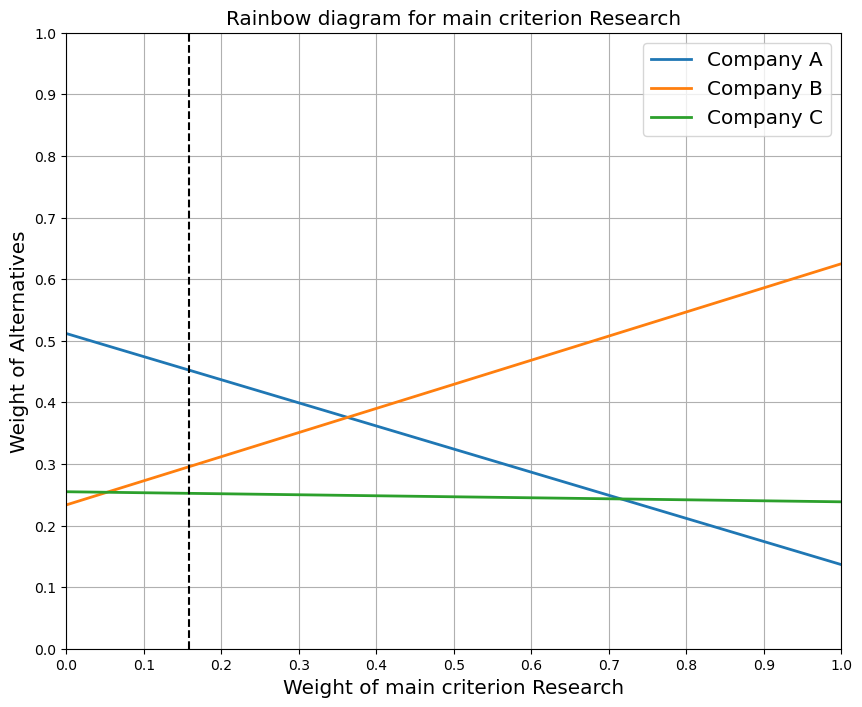

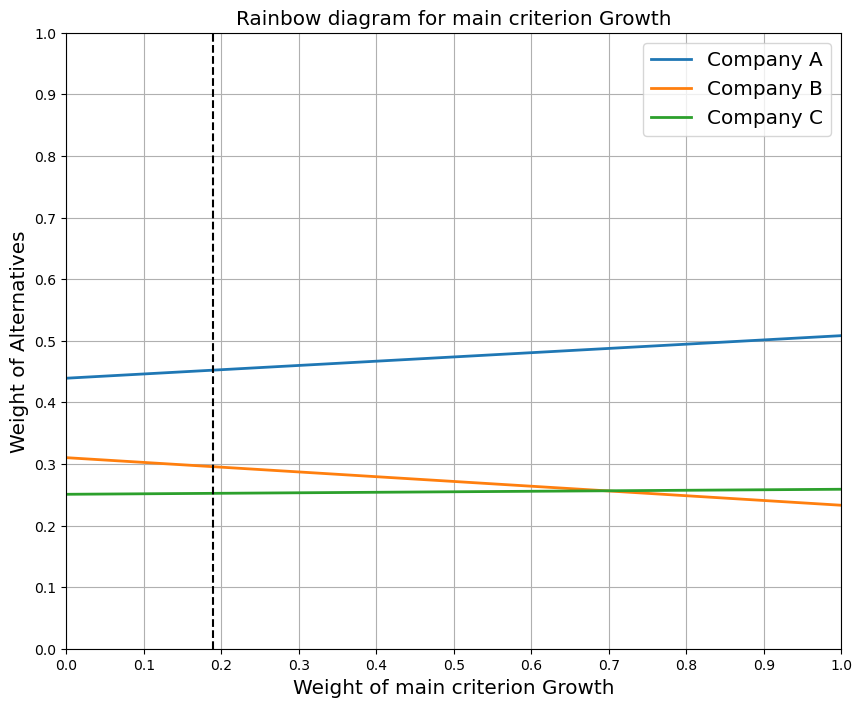

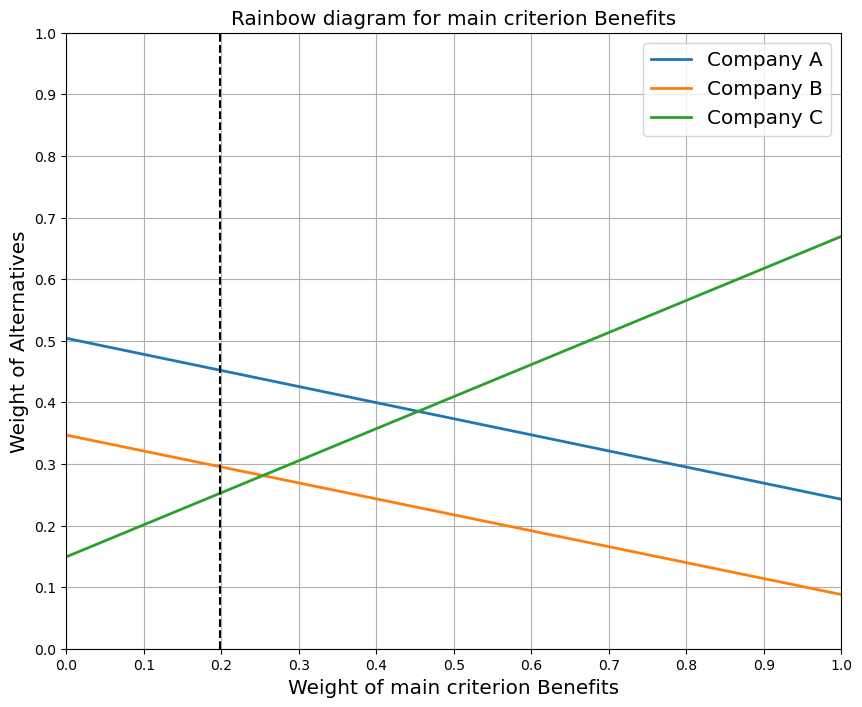

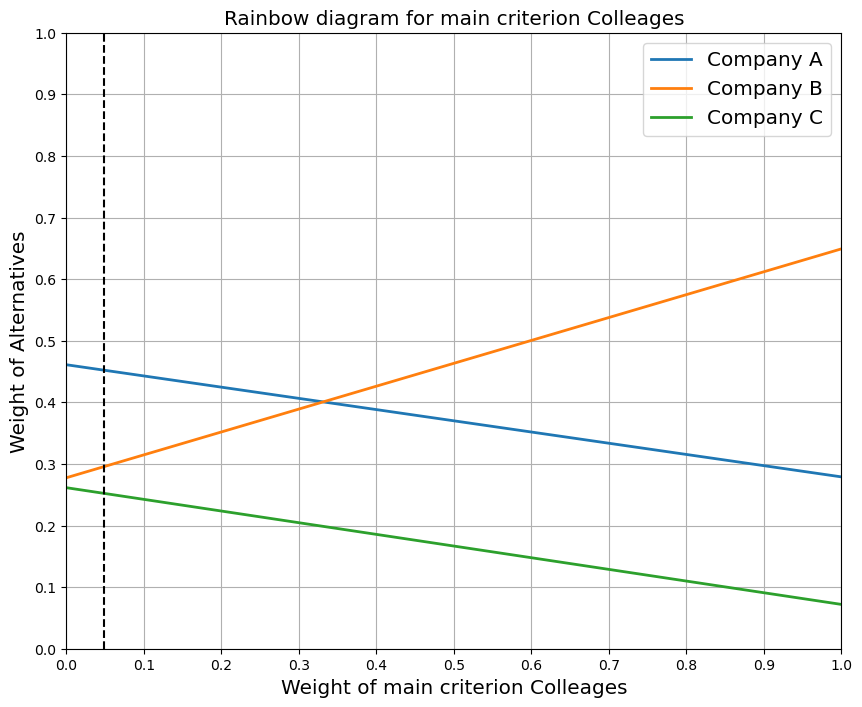

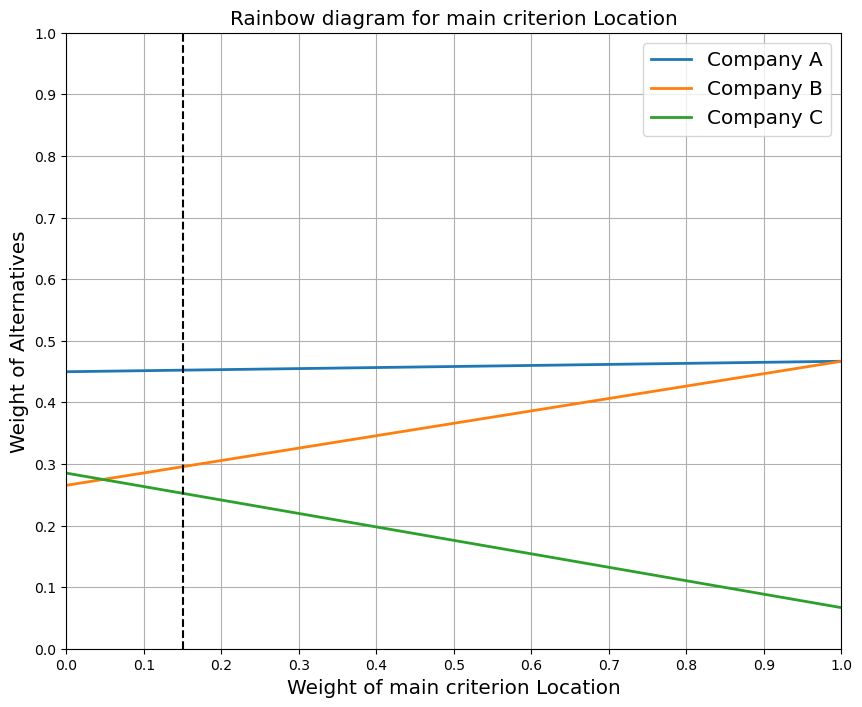

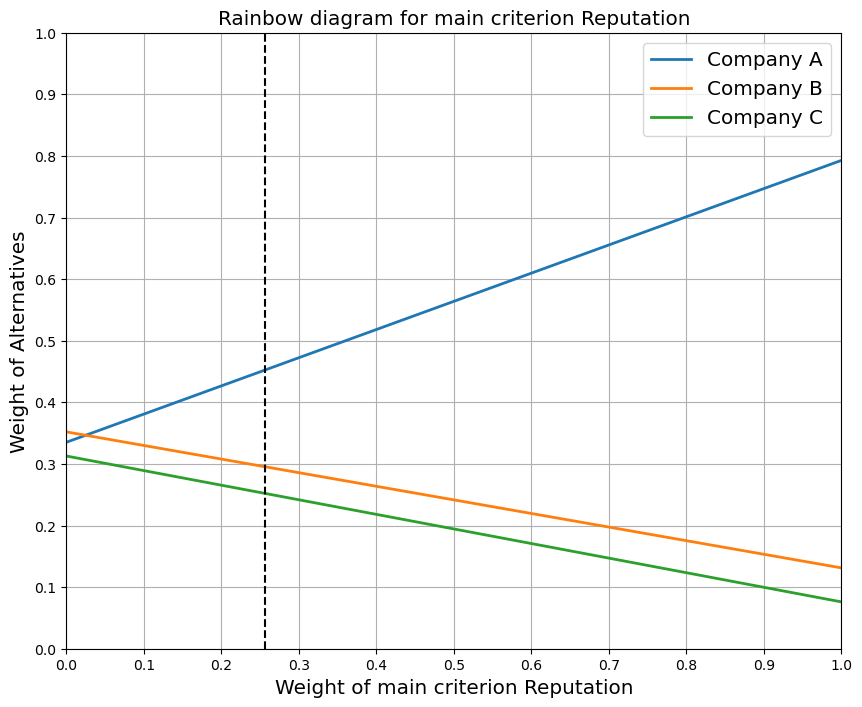

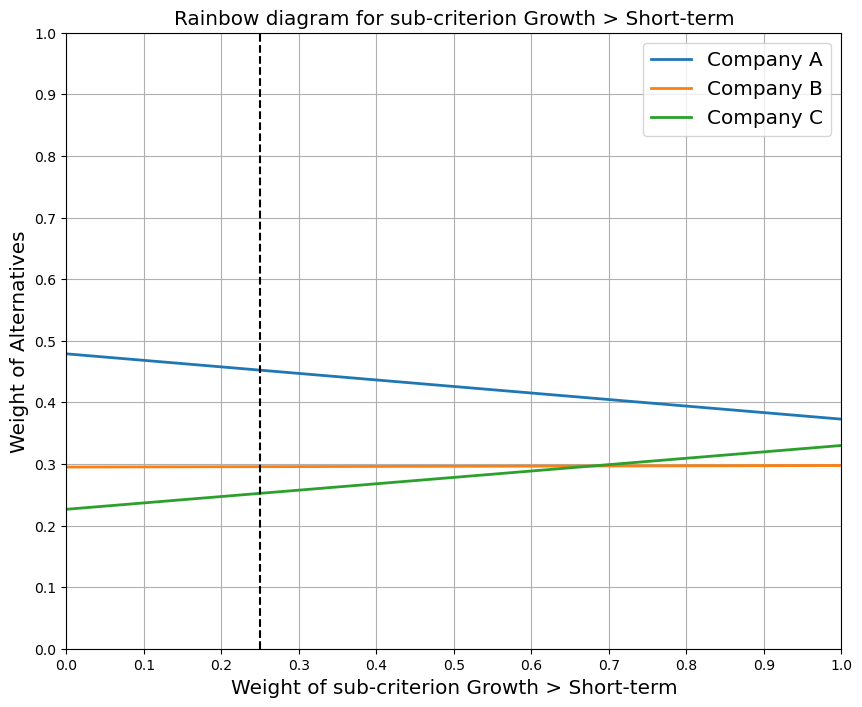

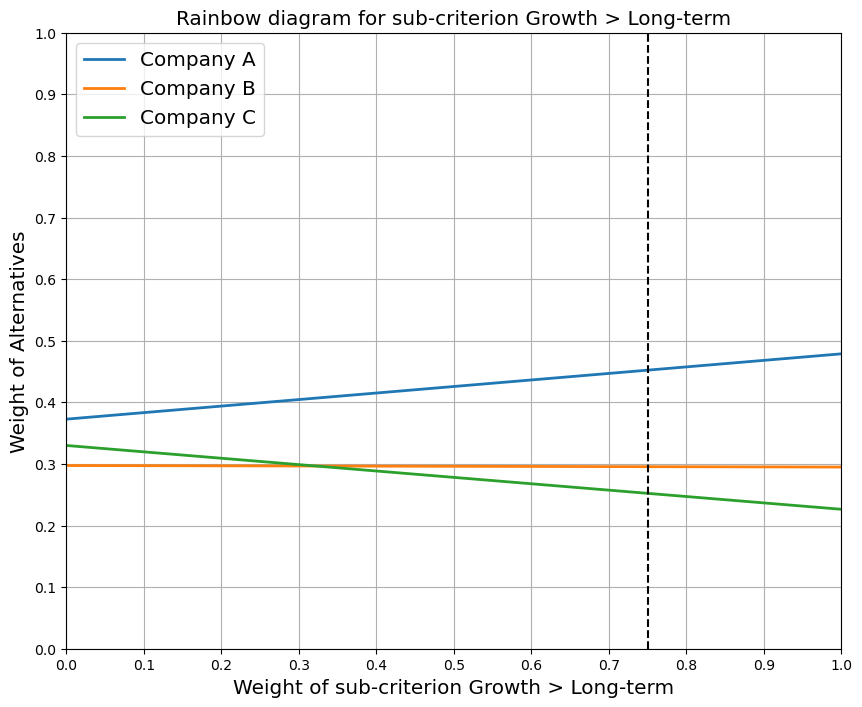

In [8]:
sensit(C, S, AL, u, v, W)